# Predicting UFC Fights

Thanks to the original author for providing the inital logic for scraping the data. Also some good ideas for the model. However, there are a few things I'd like to change. Ultimately, I think I'm going to go in a different direction. But the inital code provides a good starting point

The original project is here:
https://towardsdatascience.com/predicting-ufc-fights-with-machine-learning-5d66b58e2e3akA

Steps
- Run scraper and collect the data, ensuring you have updated data for each fighter and bout.
- Create fighter_bouts_joined table from scraped_data.db using <project_root>/SQL/fighter_botus_join_query.sql
- Clean/Format/Explore data
- Impute reach by regressing on dimensions of X

- Todo/questions:
- is harder to predict fights as rankings increase?
- Fix imputation:
- Reach
- Data to get
- Walk around weight
- Rematch? Who won the first time
- Did he  beat someone that other lost to?
- Parse styles
- ranking
- Plots
- Weight vs reach
- Height vs reach
- Height vs weight
- Weight distribution
- Height dist
- Reach | height dist
- Scale data
- Check for multi colliniearity
- Features to create
- Win loss ratio
- Split record to win/loss/draw/no contest
- Finish round avg
- Extract from website
- Total strikes thrown
- Total takedowns attempted
- Knockdowns
- Wins by KO/stoppage/submission/decision
- Fights on specific days to look at if age determines fight wins
- Does number of times KO’d determine anything
- Look at dists of features conditioned on weight or height or ranking
- Look at outliers
- Plost dists after robust
- Try standard scaler
- Plot missingness using nullity matrix
- Look at Reach predictions distribution


#### feature abbreviation meanings

- SLpM - Significant Strikes Landed per Minute
- Str. Acc. - Significant Striking Accuracy
- SApM - Significant Strikes Absorbed per Minute
- Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)
- TD Avg. - Average Takedowns Landed per 15 minutes
- TD Acc. - Takedown Accuracy
- TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)
- Sub. Avg. - Average Submissions Attempted per 15 minutes

In [2]:
import os, sys
from pathlib import Path
import pandas as pd
import sqlite3
import processor
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.insert(0, os.path.abspath('/home/justin/pycharmprojects/fight_predictor/predictor/'))
# pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# project_root = Path("/home/justin/projects/fight_predictor")
project_root = Path("/home/justin/pycharmprojects/fight_predictor")
data_dir = project_root / "predictor" / "Data" / "Scraped_Data"
scrapers_dir = project_root / "predictor" / "scrapers"
# fighters = pd.read_csv(data_dir / "scraped_fighters.csv")

In [4]:
# dbpath = scrapers_dir / 'db' / 'scraped_data.db'
dbpath = scrapers_dir  / 'db' / 'scraped_data.db.bak5'
print(dbpath)
# /home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db

/home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db.bak5


In [5]:
cnx = sqlite3.connect(dbpath)

Run if fighter_bouts_join table doesn't exist

In [6]:
# with (project_root / "SQL" / "fighter_bouts_join_query.sql").open() as sql_file:
#     sql_script = sql_file.read()
#     cnx.cursor().executescript(sql_script)
#     cnx.commit()
#     cnx.close()


#fbjdb.to_csv(data_dir / "fighter_bouts_joined.csv")

In [7]:
fdf = pd.read_sql_query("SELECT * FROM fighters", cnx)
bdf = pd.read_sql_query("SELECT * FROM bouts", cnx)
# fbdf = pd.read_sql_query("SELECT * FROM fighter_bouts_joined", cnx)

In [8]:
bdf.describe()

,pass_stat_f1,pass_stat_f2,round_,str_stat_f1,str_stat_f2,sub_stat_f1,sub_stat_f2,td_stat_f1,td_stat_f2,time
count,6940.000000,6940.000000,6940.000000,6940.00000,6940.000000,6940.000000,6940.000000,6940.000000,6940.000000,6940.000000
mean,0.539914,0.254755,2.334438,0.36830,0.064121,1.456484,0.669741,42.472478,28.042219,3.670336
std,0.949355,0.696852,1.013724,0.61031,0.269095,1.983789,1.192705,34.002869,26.527802,1.709661
min,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,17.000000,7.000000,2.290000
50%,0.000000,0.000000,3.000000,0.00000,0.000000,1.000000,0.000000,35.000000,21.000000,4.470000
75%,1.000000,0.000000,3.000000,1.00000,0.000000,2.000000,1.000000,60.000000,41.000000,5.000000
max,10.000000,7.000000,5.000000,5.00000,3.000000,21.000000,11.000000,445.000000,271.000000,18.000000


In [9]:
# bdf.isnull().sum()

# print(bdf[bdf["pass_stat_f1"] == 0]["pass_stat_f1"].count())
# print(bdf[bdf["pass_stat_f2"] == 0]["pass_stat_f2"].count())
# print(bdf[bdf["pass_stat_f1"] == 0]["pass_stat_f1"].count())
# print(bdf[bdf["pass_stat_f2"] == 0]["pass_stat_f2"].count())
# print(bdf[bdf["str_stat_f1"] == 0]["str_stat_f1"].count())
# print(bdf[bdf["str_stat_f2"] == 0]["str_stat_f2"].count())
# print(bdf[bdf["sub_stat_f1"] == 0]["sub_stat_f1"].count())
# print(bdf[bdf["sub_stat_f2"] == 0]["sub_stat_f2"].count())
# print(bdf[bdf["td_stat_f1"] == 0]["td_stat_f2"].count())
# print(bdf[bdf["td_stat_f2"] == 0]["td_stat_f2"].count())
# print(bdf[bdf["time"] == 0]["time"].count())
#

In [10]:
# name = "Anderson Silva"
# bdf[(bdf.fighter1 == name) | (bdf.fighter2 == name)]

### Inspect Fighter dataframe

Look at distributions. Search for potential outliers.

In [11]:
fdf.describe()

,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight
count,2000.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3922.000000,3846.000000
mean,71.666500,3.068990,2.372708,35.275115,42.541560,0.629398,26.307241,1.245992,38.784294,171.435257
std,4.224358,2.758817,1.929794,20.540777,22.603824,1.585970,28.872155,1.954198,34.374913,39.754295
min,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000
25%,69.000000,1.530000,0.800000,26.000000,35.000000,0.000000,0.000000,0.000000,0.000000,145.000000
50%,72.000000,2.870000,2.270000,40.000000,50.000000,0.000000,22.000000,0.570000,42.000000,170.000000
75%,75.000000,4.120000,3.530000,49.000000,58.000000,0.700000,45.000000,1.930000,66.000000,185.000000
max,84.000000,52.500000,22.110000,100.000000,100.000000,23.700000,100.000000,32.140000,100.000000,770.000000


Let's start by plotting the intuitive correlations. For instance, below we plot height vs reach as they are probably linearly related.

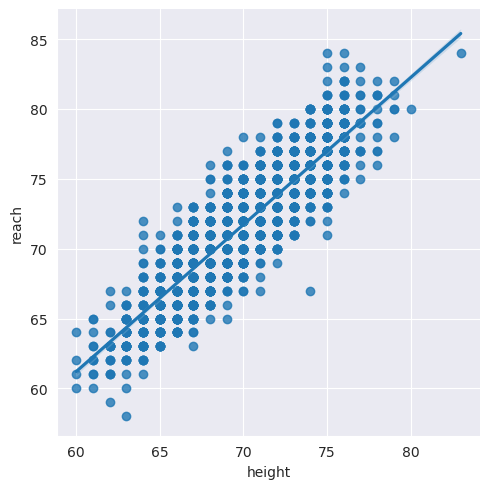

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def parse_fighter_height(height):
    if height:
        if '"' in height:
            height = height.replace('"', '')
        ht = height.split("' ")
        ft = float(ht[0])
        inch = float(ht[1])

        return (12 * ft) + inch
    else:
        pass


fdf = fdf[fdf["height"] != "--"]
fdf["height"] = fdf["height"].apply(lambda x: parse_fighter_height(x))
tempdf = fdf[["height", "reach"]].dropna()
sns.lmplot(data=tempdf, x="height", y="reach")
plt.show()


Reach and height are clearly correlated. Also, we can see that reach is dependent on some kind of distribution. That is, we can see the y values are stacked. That means that the Y values are distributed based on some kind of value, in this case it seems like it's height, but it's probably weight. In other words, there is a reach distribution for each weight class, which makes sense intuitively. Middleweights should have a different average reach than featherweights. This is good to see explicitly.

As an aside, reach is also probably conditioned on height, but weight is a better stratifier

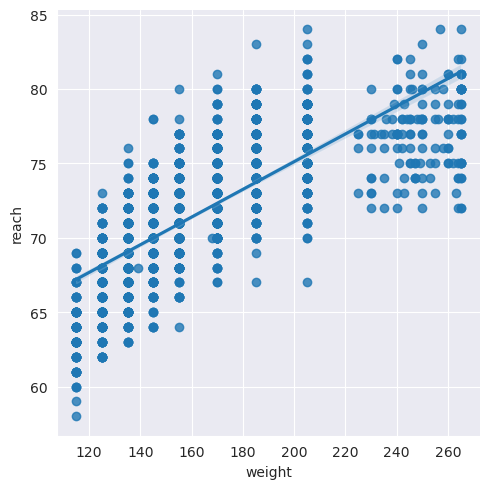

In [13]:
tempdf = fdf[["weight", "reach"]].dropna()
sns.lmplot(data=tempdf, x="weight", y="reach")
plt.show()

Let's look at a few distributions of reach conditioned on weight

<AxesSubplot:xlabel='reach', ylabel='Density'>

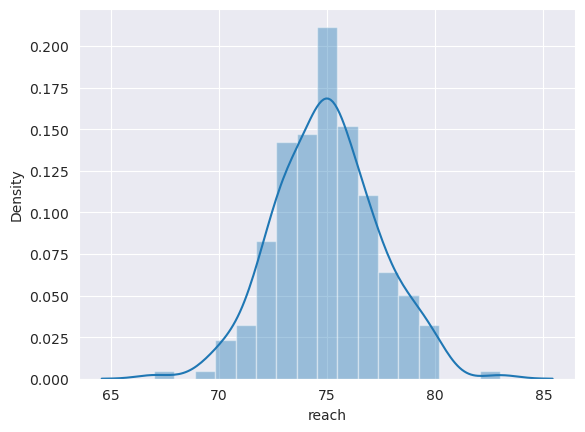

In [14]:
sns.distplot(fdf[fdf["weight"] == 185]["reach"])

<AxesSubplot:xlabel='reach', ylabel='Density'>

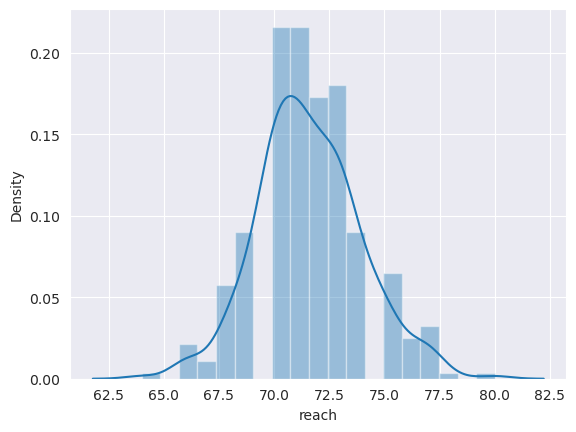

In [15]:
sns.distplot(fdf[fdf["weight"] == 155]["reach"])

Clearly, according to the above, reach has different expectations when conditioned on weight class, and probably also when conditioned on some height range.


Moving on, let's clean the fighter data further

In [16]:
# import re
# # s = "Record: 19-7-1 (1 NC)"
# s2 = "Record: 9-7-1"
# s3 = "Record: 90-7-1"
# s4 = "Record: 19-7-1"
# s5 = "Record: 534-7-1"
# # val = re.search('\(([^)]+)', s2)
#
# # sp = s2.split("-")
# # sp = s3.split("-")
# # sp = s4.split("-")
# sp = s5.split("-")
# print(sp)
# match = re.search('[0-9]+', sp[0])
# print(match)
# i = match.start()
# j = match.end()
# print(i, j)
# print(sp[0][i:j])

Let's parse the fighter_record column into win, loss, draw, and no contest columns. Also, create the features win/loss ratio and total fight record, which is just the total number of fights a fighter has, as this might determine experience. These might be useful.

In [17]:
import re

def parse_nocontest(x):
    if "NC" in x:
        nc_record = re.search('\(([^)]+)', x).group(1)[0]
        return int(nc_record)
    return 0


def parse_record(x):
    sp = x.split("-")
    match = re.search('[0-9]+', sp[0])
    win = int(sp[0][match.start():match.end()])
    loss, draw = int(sp[1]), int(sp[2][0])
    ratio = win/loss if win != 0 and loss != 0 else 0
    return pd.Series([win, loss, draw, ratio])


fdf["no_contest"] = fdf.fighter_record.apply(parse_nocontest)
fdf[["win", "loss", "draw", "win_loss_ratio"]] = fdf.fighter_record.apply(parse_record)
fdf["total_fights"] = fdf["win"] + fdf["loss"] + fdf["draw"] + fdf["no_contest"]
# fdf["win_loss_ratio"] = (fdf["win"] / fdf["loss"]).round(3)
fdf

,date_of_birth,fighter_name,fighter_record,height,reach,sapm,slpm,stance,strike_acc,strike_def,...,td_acc,td_avg,td_def,weight,no_contest,win,loss,draw,win_loss_ratio,total_fights
0,Mar 02 1992,Hunter Azure,Record: 9-2-0,68.0,69.0,2.08,3.92,Orthodox,53,58,...,34,1.97,67,145.0,0,9.0,2.0,0.0,4.500000,11.0
1,Jul 17 1990,Michael Byrnes,Record: 5-3-0,71.0,NaN,0.00,0.00,,0,0,...,0,0.00,0,155.0,0,5.0,3.0,0.0,1.666667,8.0
2,Feb 07 1989,Gleidson Cutis,Record: 7-4-0,69.0,NaN,8.28,2.99,Orthodox,52,59,...,0,0.00,0,155.0,0,7.0,4.0,0.0,1.750000,11.0
3,Aug 11 1990,Rolando Dy,Record: 9-7-1 (1 NC),68.0,69.0,4.47,3.04,Orthodox,37,52,...,20,0.30,68,145.0,1,9.0,7.0,1.0,1.285714,18.0
4,Jul 27 1986,Jessica Eye,Record: 15-11-0 (1 NC),66.0,66.0,4.19,3.86,Orthodox,37,55,...,40,0.58,57,125.0,1,15.0,11.0,0.0,1.363636,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,Jun 29 1983,Ricky Rainey,Record: 12-6-0,73.0,77.0,2.62,2.55,Switch,48,46,...,18,0.95,55,170.0,0,12.0,6.0,0.0,2.000000,18.0
3918,Dec 07 1974,Amir Rahnavardi,Record: 11-10-0,72.0,NaN,0.00,0.67,Orthodox,25,100,...,0,0.00,50,205.0,0,11.0,10.0,0.0,1.100000,21.0
3919,Jan 06 1981,Josh Rafferty,Record: 9-8-0,72.0,NaN,3.60,0.60,Orthodox,33,50,...,0,0.00,0,170.0,0,9.0,8.0,0.0,1.125000,17.0
3920,--,Gilbert Rael,Record: 1-3-0,68.0,NaN,7.46,0.00,,0,37,...,100,4.86,0,155.0,0,1.0,3.0,0.0,0.333333,4.0


Plot the correlation heatmap to view any obvious correlations. Typically, we remove highly correlated features. That is, if we have features x1 and x2 that are highly correlated, we remove either x1 or x2, whichever makes more sense. There are a few highly correlated features, like (height, reach) and (weight, reach), but this doesn't mean we should remove the features necessarily. Each feature still provides independent pieces of information I think. For instance, a height and reach might be related, but height and reach could still affect the fight independently.

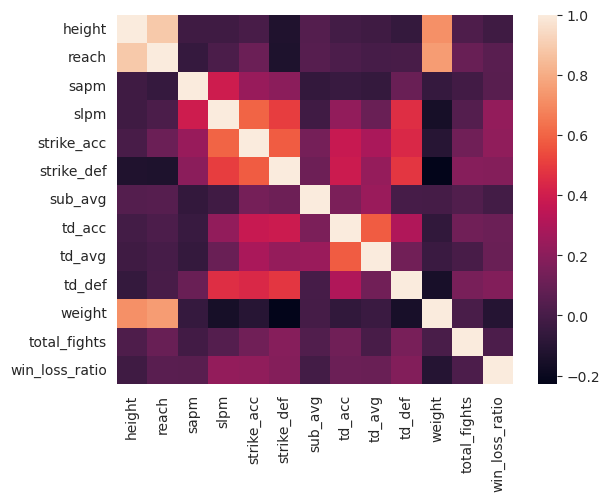

In [18]:
# columns = ['date_of_birth', 'fighter_name', 'fighter_record', 'height', 'reach',
#        'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
#        'td_acc', 'td_avg', 'td_def', 'weight', 'dob', 'no_contest', 'win',
#        'loss', 'draw', 'total_fights', 'win_loss_ratio']
correlation_columns = ['height', 'reach', 'sapm', 'slpm',
                       'stance', 'strike_acc', 'strike_def',
                       'sub_avg', 'td_acc', 'td_avg', 'td_def',
                       'weight', 'total_fights', 'win_loss_ratio']

# sns.pairplot(fdf[correlation_columns])
corcolsdf = fdf[correlation_columns]
sns.heatmap(corcolsdf.corr())
plt.show()

In [19]:
# Create correlation matrix
corr_matrix = corcolsdf.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,height,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,total_fights,win_loss_ratio
height,NaN,0.886682,0.027138,0.025259,0.004519,0.125197,0.039699,0.010624,0.026869,0.059380,0.721169,0.021868,0.027626
reach,NaN,NaN,0.052039,0.014016,0.107904,0.131577,0.045546,0.019998,0.000573,0.003517,0.754674,0.099370,0.054128
sapm,NaN,NaN,NaN,0.392108,0.236662,0.199030,0.062118,0.043800,0.059399,0.106378,0.053038,0.017440,0.053579
slpm,NaN,NaN,NaN,NaN,0.600601,0.505000,0.022191,0.220770,0.104112,0.458769,0.156257,0.042644,0.224649
strike_acc,NaN,NaN,NaN,NaN,NaN,0.578807,0.136801,0.373107,0.288292,0.440427,0.101190,0.124966,0.212484
strike_def,NaN,NaN,NaN,NaN,NaN,NaN,0.113119,0.389962,0.229227,0.484644,0.229328,0.187869,0.180276
sub_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156489,0.242085,0.000057,0.003938,0.034072,0.010769
td_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.579144,0.306304,0.066949,0.122049,0.106910
td_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129186,0.039534,0.004685,0.103323
td_def,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151105,0.147189,0.177446


In [20]:
# Correlated pairs
# (height, reach) .8
# (strike_acc, slpm) .6
# (strike_def, slpm) .5
# (strike_acc, strike_def) .57
# (td_acc, td_avg) .58
# (weight, height) .72
# (weight, reach) .75

### Missing Data



Using a nullity matrix is my favorite way of immediately viewing missing data. We can see date of birth (DOB) and reach are missing a quite a few values, and they are important features. We will try to predict reach by regressing on the other columns. DOB might be a bit trickier. Perhaps we can think of a clever way to estimate those values. For now, I think a mean estimation for DOB might be the best bet

In [21]:
replacedash = lambda x: np.nan if x == "--" else x
fdf["dob"] = fdf["date_of_birth"].apply(replacedash)
fdf["dob"] = pd.to_datetime(fdf["dob"])

<AxesSubplot:>

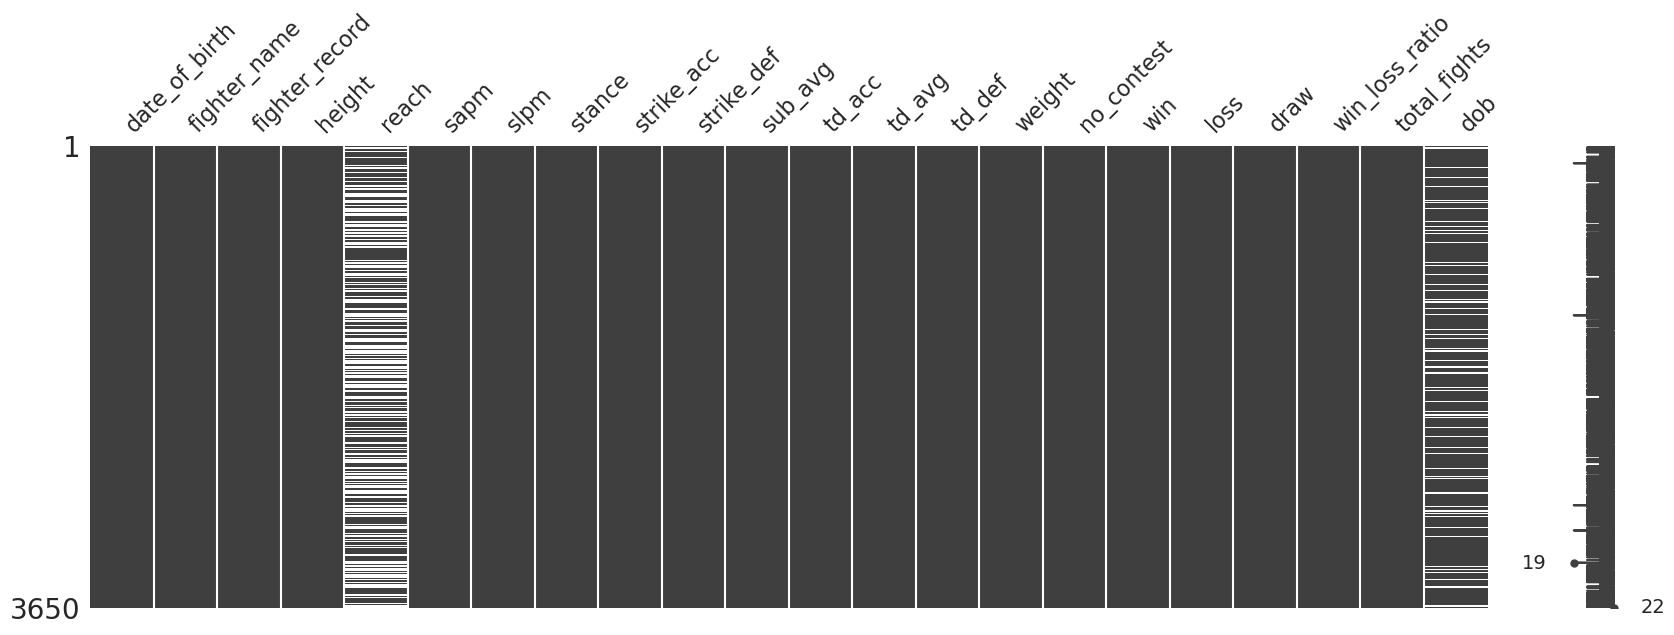

In [22]:
import missingno as mno

mno.matrix(fdf, figsize = (20, 6))

In [23]:
from datetime import datetime, date

# This function converts given date to age
def age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

fdf["age"] = fdf['dob'].apply(age)

### Impute DOB and fighter reach


Now we need to tackle fighter reach. The original author of this project imputed (estimated) fighter reach using the mean (population average). This is potentially biasing the model: reach is probably a strong predictor of fight success, interacting with variables like strike_acc to create an effect. Also, the distribution of reach changes when conditioned on height, so we know that using overall population mean for reach is probably not a good idea

Can we estimate fighter reach by regressing on other dimensions of the fighter?

In [24]:
from sklearn.model_selection import train_test_split

columns_scale = ['height', 'sapm', 'slpm', 'strike_acc', 'strike_def', 'sub_avg',
           'td_acc', 'td_avg', 'td_def', 'weight', 'no_contest', 'win',
           'loss', 'draw', 'total_fights', 'win_loss_ratio', 'reach', "age"]

# DROP NA!
# fdf_na_all = fdf.isna()
# fdf_drop_na = fdf[columns_scale].dropna()
# len(fdf_drop_na)

#### KNN Imputation

In [25]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights="uniform")
knn_imputed_data = pd.DataFrame(imputer.fit_transform(fdf[columns_scale]), columns=columns_scale)

<AxesSubplot:>

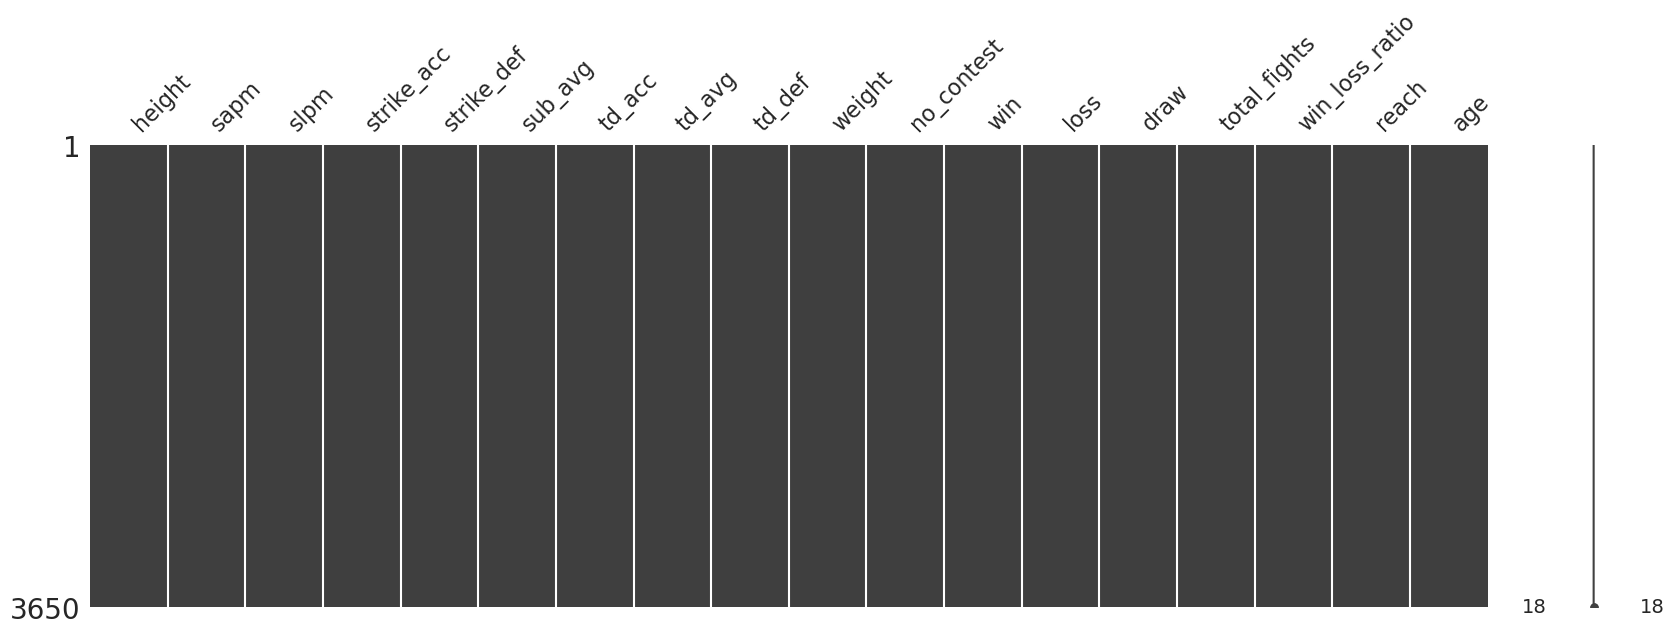

In [26]:
mno.matrix(knn_imputed_data, figsize = (20, 6))

In [27]:
knn_imputed_data["reach_old"] = fdf["reach"]
toplot = knn_imputed_data[knn_imputed_data["reach_old"].isna()]

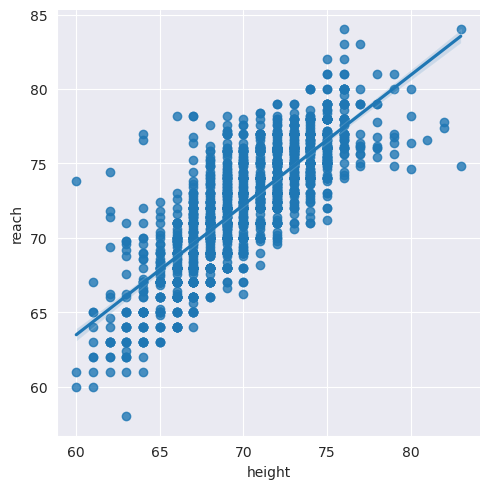

In [28]:
sns.lmplot(data=toplot[["height", "reach"]], x="height", y="reach")
plt.show()

<AxesSubplot:>

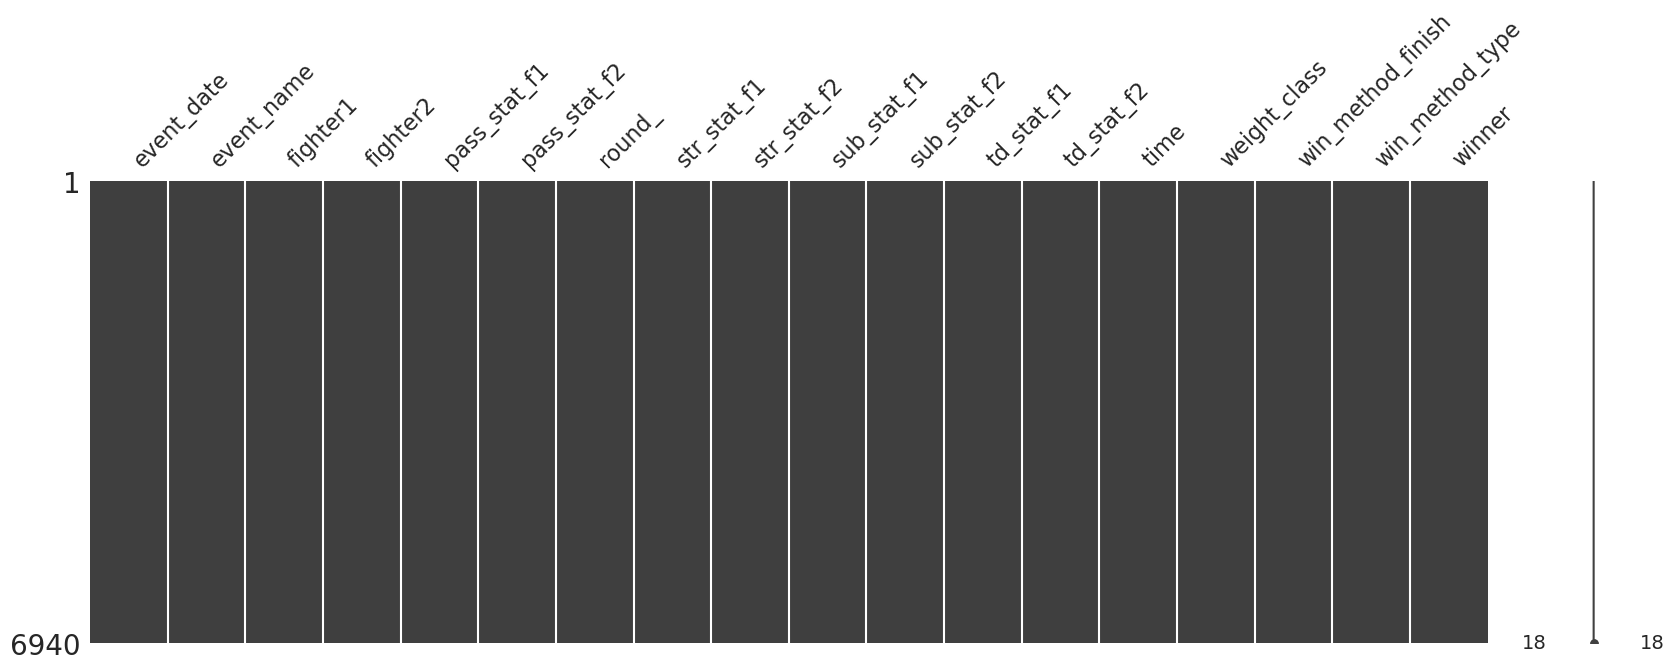

In [29]:
mno.matrix(bdf, figsize = (20, 6))

Looks like theres no missing data. Let's join the fighters data frame to the bouts data frame on key=fighter_name

##### Scale features

We scale our features when different features are on different scales. That is, they have significantly different expectations and variations in their distributions. Without scaling, the model will learn to place disproportionate emphasis on certain weights, which can lead to problems like high model variance. Let's apply quantile scaling and view it's affect on separate distributions. Quantile scaling transforms your data as follows
$$
\frac{x - median}{Q_3(x) - Q_1(x)}
$$

That is, it removes the median and scales by the 3rd and 1st quantiles. This scaler is good because it is robust to outliers.

In [28]:
columns_predict = ['height', 'sapm', 'slpm', 'strike_acc', 'strike_def', 'sub_avg',
           'td_acc', 'td_avg', 'td_def', 'weight', 'total_fights', 'win_loss_ratio']
X, y = knn_imputed_data[columns_predict], knn_imputed_data["reach"]
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [29]:
from sklearn.preprocessing import RobustScaler

# scaler = StandardScaler()
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

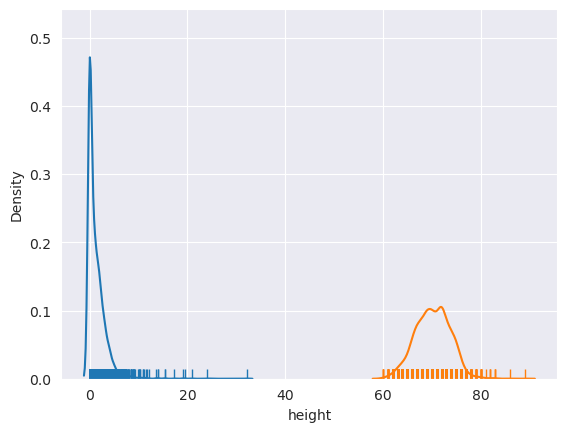

In [30]:
sns.distplot(X_train_["td_avg"], hist=False, rug=True)
sns.distplot(X_train_["height"], hist=False, rug=True)
plt.show()

Below, we can see how quantile scaling yields similar distributions for both height and takedown average.

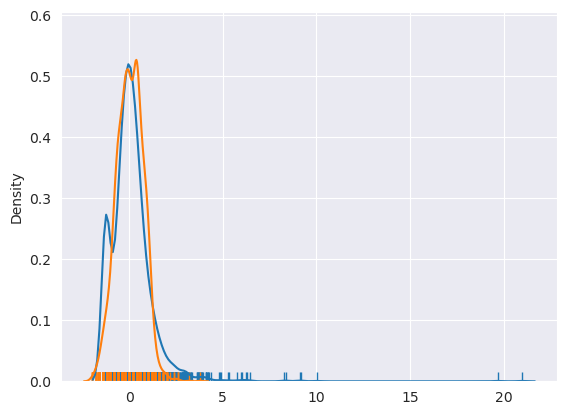

In [31]:
sns.distplot(X_train[:, 1], hist=False, rug=True)
sns.distplot(X_train[:, 0], hist=False, rug=True)
plt.show()